In [85]:
import numpy as np
import matplotlib.pyplot as plt
import ctypes as c 
import tqdm
import pickle

import swimAD2 as ad2       # copy swimAD2.py to your working directory
import time

ad2.disconnect()            # close all instances before connecting
zoroku = ad2.connect(0)      # connect to first(0th) ad2, give it the name 'zoroku'

In [86]:
# Set the measurement parameters. 

res1 = 19295.6601 # Values of the resistances in Ohms. \
res1std = 0.0003516
res2 = 10

def prepare_measurement(inpt,hertz,points,settingoffset):
    ad2.config_wavegen(
        zoroku,                                    # name of device
        frequency=1,                           # max 10 MHz
        amplitude=inpt,                              # max 5 V
        signal_shape=ad2.dwfc.funcSine,         # output signal shape: funcSine, funcSquare, funcTriangle, funcRampUp, funcRampDown, funcNoise
        offset=settingoffset,                               # signal voltage offset
        # phase=0,                                # signal phase
        # symmetry=50,                            # signal symmetry shape
        # channel=0                               # channel 0 / 1 (or -1 for all channels)
    )
    ad2.config_oscilloscope(
        zoroku,                        # name of device
        range0=5,                     # Oscilloscope Channel 0 voltage range, max 25 V
        range1=20,                     # Oscilloscope Channel 2 ref
        sample_rate=hertz,           # max 100 MHz
        sample_size=points,           # max 8192, sample time = sample_size / sample_rate
        )
    return


In [87]:
# Create the np.array of input voltages

n_volt = np.linspace(0.1,5,num=50)
input_dict = {}
for volt in n_volt:
    input_dict[round(volt,2)] = []
print('testing voltage is',n_volt)

# Perform the measurement

hertz=80000 # Frequency of detections by Zoroku in Hz, max 100MHz.
samp_time = 0.1 # Duration of our measurement in s. 
n_trial = range(0,1) # Number of trials per voltage. 
print('sampling frequency is', hertz,'Hz')
points=int(hertz*samp_time)
if points > 8192:
    print("OverflowError") # Activates over maximum resolution. 
    points = 8192
print(points)

for volt in n_volt:
    for i in n_trial: # Specify the number of trials per voltage.
        #print('in', volt, 'V','trial number is',i+1)
        prepare_measurement(0,hertz,points,volt)
        ad2.start_wavegen(zoroku,channel=0)

        # Cheong SY. gives time to stabilise the signal, 
        # but we shall ignore this step and analyse the impact of this.
        time.sleep(0.7)

        t, v0, v1 = ad2.measure_oscilloscope(zoroku)
        voltage = volt*np.ones(np.size(t))
        a = np.array([v0,v1])
        output = np.transpose(a)
        input_dict[round(volt,2)]=output
        ad2.stop_wavegen(zoroku, channel=0)
        print(volt)
with open("step1_ex1_res_"+str(res2)+'.pkl',"wb") as handle:
    pickle.dump(input_dict,handle,protocol=pickle.HIGHEST_PROTOCOL)


testing voltage is [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6
 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5. ]
sampling frequency is 80000 Hz
8000
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0


In [88]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib
import pickle
res1 = 19295.6601 # Values of the resistances in Ohms. 
res1std = 0.0003516
res2 = 10
with open("step1_ex1_res_"+str(res2)+'.pkl',"rb") as handle:
    A = pickle.load(handle)
#print(A)
#print(A)
n = len(A)      # number of voltage
m = len(A.get(list(A.keys())[0]))       # number of measurement in each voltage
#print(n,m)
B = {}       # temporary storage
C = []       # [input voltage, V1/V2, 1 sigma error]
for i in range(20):      
    for j in range(m):
        ratio = A.get(list(A.keys())[i+30])[j][0]/A.get(list(A.keys())[i+30])[j][1]
        C.append(ratio)
mean = np.mean(C)
std = np.std(C, ddof = 1)/(((n-30)*m)**0.5)   

print('Resistance of DUT: '+ str(round(mean*res1,4)) +'±'+str(round(((res1*std)**2+(mean*res1std)**2)**0.5,4)))



Resistance of DUT: 31.2495±0.0088


50 8000
params:
 [-0.0025897  0.0109603]
covariance:
 [[ 2.40464175e-07 -6.13183647e-07]
 [-6.13183647e-07  2.06438495e-06]]


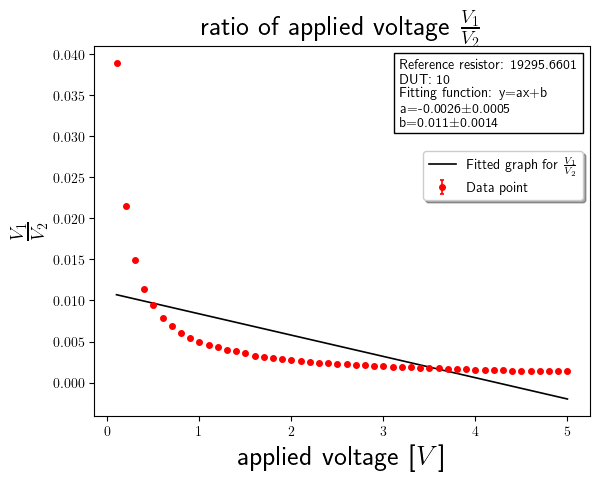

In [89]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib
import pickle
res1 = 19295.6601 # Values of the resistances in Ohms. 
res2 = 10
with open("step1_ex1_res_"+str(res2)+'.pkl',"rb") as handle:
    A = pickle.load(handle)
n = len(A)      # number of voltage
m = len(A.get(list(A.keys())[0]))       # number of measurement in each voltage
print(n,m)
n_volt = np.linspace(0.1,5,num=50)
mean = []
stdv = []
for i in range(n):      
    C = []
    for j in range(m):
        ratio = A.get(list(A.keys())[i])[j][0]/A.get(list(A.keys())[i])[j][1]
        C.append(ratio)
    mean.append(np.mean(C))
    stdv.append(np.std(C, ddof = 1)/((m)**0.5))
x = np.linspace(0.1,5,num=50)
y = mean

def func(x, A, B):
    return A*x+ B

popt, pcov = curve_fit(func, x, y)
print("params:\n", popt)
print("covariance:\n", pcov)
a, b= popt[0], popt[1]
yfit = a*x+b
max = list(A.keys())[-1]
fig, ax = plt.subplots()
ax.plot(x, func(x, a, b),
    linestyle="-",
    linewidth=1.2,
    color="k",
    label=r"Fitted graph for $\frac{V_1}{V_2}$")

ax.errorbar(x, y, yerr=stdv,
    marker='o',
    markersize=4,
    linestyle="None",
    elinewidth=1.2,
    capsize=1.5,
    capthick=1.2,
    color="r",
    label="Data point")
textstr = 'Reference resistor: '+str(res1)+'\nDUT: '+str(res2)+'\nFitting function: y=ax+b'+'\na='+str(round(popt[0], 4))+r'$\pm$'+str(round(pcov[0][0]**0.5, 4))+'\nb='+str(round(popt[1], 4))+r'$\pm$'+str(round(pcov[1][1]**0.5, 4))
textbox = matplotlib.offsetbox.AnchoredText(textstr, loc='upper right')
ax.add_artist(textbox)

plt.rc('text', usetex = True)
#plt.xkcd()
plt.title(r'ratio of applied voltage $\frac{V_1}{V_2}$', fontsize = 20)

plt.ylabel(r'$\frac{V_1}{V_2}$', fontsize = 20)
plt.xlabel(r'applied voltage [$V$]', fontsize = 20)
plt.legend(loc='center right', bbox_to_anchor=(1, 0.65) ,fancybox=True, shadow=True)
plt.grid(False)
plt.savefig("step1_ex1_res_"+str(res2)+'.png')
plt.show()
